In [11]:
# 사용하려는 라이브러리 호출 및 저장
import bok_python as bp
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 구성함수 (상위함수와 사용되는 하위함수)
- `COINT_test`: VAR 모형 내 공적분에 대한 검정 (Johansen System Method)

    - `VECM_MLE`: Johansen의 MLE 방법을 사용한 VECM 모형 추정

    - `read_table`: Johansen System Method로 귀무가설 검정 시 Osterwald-Lenum (1992)의 임계값 표에 기반한 절편항 제외 및 절편항 포함 VECM 모형의 rank 추정

- `VECM_IRF`: VECM 모형 추정 후 VAR 모형으로 변환하여 충격반응함수 도출 (신뢰구간은 도출하지 않음)

    - `VECM_MLE`: 추정된 공적분 벡터의 rank를 사용하여 VECM 모형 추정

    - `recover_VAR`: 추정된 VECM 모형의 추정량을 VAR 모형의 형태로 복원

    - `irf_estimate`: 충격반응함수 추정

## 2. 데이터 불러오기
- 패키지를 적용하기 위해 데이터를 불러오자.

데이터는 한국의 전기대비 실질 GDP 성장률, CD91일 금리, 인플레이션율 소비자 가격 지수 (Consumer Price Index, CPI), CD91일 금리로 1999년 4분기부터 2023년 4분끼지의 분기별 자료이다. 해당 데이터는 ECOS (https://ecos.bok.or.kr/#/)에서 다운로드 받았으며 컴퓨터에 "python_data.xlsx"라는 이름의 엑셀파일의 "KORmacro"라는 시트에 저장되어 있다. 이때, 인플레이션율의 경우 소비자 가격 지수 (Consumer Price Index, CPI)의 전년동기대비 치분 (YoY)을 통해 미리 변환한 것이다.

In [12]:
dataset = pd.read_excel('./test_data/python_data.xlsx', sheet_name='KORmacro')
data = pd.DataFrame(dataset)
sample = data.copy() # 2000 Q4 ~ 2023 Q4
sample.columns = ['Date', 'rGDP', 'cd91', 'cpi']
sample = sample.drop(columns='Date')
Y = bp.matrix(sample)
y = np.hstack((Y[:,2], Y[:,0], Y[:,1])) # inf, rgdp, cd91
print(y)

[[ 2.50825674 -0.3         6.97      ]
 [ 3.62787647  1.2         5.95      ]
 [ 4.91977836  1.3         5.78      ]
 [ 4.15845571  1.4         4.97      ]
 [ 3.24432712  1.8         4.58      ]
 [ 2.49312186  2.5         4.66      ]
 [ 2.65301778  1.8         4.82      ]
 [ 2.48327342  2.          4.84      ]
 [ 3.26274729  1.1         4.91      ]
 [ 3.99447248 -0.7         4.67      ]
 [ 3.25179791 -0.2         4.43      ]
 [ 3.11885552  1.9         3.96      ]
 [ 3.46197014  2.6         4.17      ]
 [ 3.19518718  1.3         4.09      ]
 [ 3.35335611  0.8         3.91      ]
 [ 4.24041364  0.4         3.71      ]
 [ 3.31458915  0.8         3.44      ]
 [ 3.19908562  0.9         3.54      ]
 [ 2.93407558  1.9         3.51      ]
 [ 2.30935249  1.5         3.57      ]
 [ 2.43250478  1.          3.98      ]
 [ 2.06002426  1.6         4.22      ]
 [ 2.21389642  0.7         4.39      ]
 [ 2.49257567  1.6         4.65      ]
 [ 2.10258113  0.8         4.64      ]
 [ 1.98337999  1.7       

## 3. VECM 모형의 공적분 검정

#### 구문
`bp` 패키지 속의 `COINT_test`라는 함수를 사용하면 장기 분산을 추정할 수 있다. 이때, `COINT_test`라는 함수는 다음과 구성되어 있다.

> *<p style="font-size:20px">`rank,LR_test = bp.COINT_test(y,option,c,sig_level,p=None)`</p>*
> *<p style="font-size:15px">VAR 모형의 공적분 검정, Johansen System Method</p>*
> - **입력**:
</br></br>
    `y`: 사용하는 VAR 모형의 반응변수
    </br></br>
    `option`: 사용하고자하는 모형의 종류
    </br></br>
          `1`: 상수항이 존재하는 모형 (상수항이 공적분 관계에 대한 제약이 없는 VECM 모형)
        </br></br>
          `2`: 상수항이 존재하지 않는 모형 (상수항이 공적분 관계에 대한 제약이 있는 VECM 모형)
        </br></br>
    `c`: 사용하고자하는 검정 통계량의 종류
    </br></br>
          `1`: LR 대각합 (trace) 통계량
        </br></br>
          `2`: LR 최대 고유값 (maximum eigenvalue) 통계량
        </br></br>
    `sig_level`: 검정에 사용할 유의수준 (잘못된 기각의 확률)
    </br></br>
          `10`: 10% 유의수준
        </br></br>
          `5`: 5% 유의수준
        </br></br>
          `1`: 1% 유의수준
        </br></br>
    `p`: VAR 모형의 최적 시차 (default = None)
    </br></br>
> - **출력**:
</br></br>
    `rank`: 공적분 rank 추정치
    </br></br>
    `LR_test`: LR 검정 통계량 (대각합 통계량 또는 최대 고유값 통계량)
    </br></br>
> - **함께 사용되는 함수**:
</br></br>
    `VECM_MLE`: Johansen의 MLE 기법으로 추정한 VECM 모형
    </br></br>
    `read_table_VECM`: Johansen System Method로 귀무가설 검정 시 Osterwald-Lenum (1992)의 임계값 표에 기반한 절편항 제외 및 절편항 포함 VECM 모형의 rank 추정
    </br></br>


---

`COINT_test` 함수와 함께 사용되는 함수들은 아래와 같이 구성되어 있다.

>> *<p style="font-size:20px">`alpha,beta,Gamma,Lam,Sigmau,u_hat,phat = bp.VECM_MLE(y,r,option,p=None)`</p>*
>> *<p style="font-size:15px">Johansen의 MLE 기법으로 추정한 VECM 모형, Johansen (1992)</p>*
>> - **입력**:
</br></br>
    `y`: 사용하는 VECM 모형의 반응변수
    </br></br>
    `r`: 추정, 또는 가정된 VECM 모형의 rank
    </br></br>
    `option`: 사용하고자하는 모형의 종류
    </br></br>
          `1`: 상수항이 존재하는 모형 (공적분 관계에 대한 제약이 없는 상수항을 가지는 VECM 모형)
        </br></br>
          `2`: 상수항이 존재하지 않는 모형 (공적분 관계에 대한 제약이 있는 상수항을 가지는 VECM 모형)
        </br></br>
    `p`: VECM 모형의 최적 시차 (default = None)
    </br></br>
>> - **출력**:
</br></br>
    `alpha`: 오차 수정항 (error correction term)
    </br></br>
    `beta`: 공적분 벡터
    </br></br>
    `Gamma`: 차분항들의 계수 추정치
    </br></br>
    `Lam`: 내림차순으로 정렬된 고유값, 공적분 검정에 사용
    </br></br>
    `Sigmau`: 백색잡음과정 오차항에 대한 분산-공분산 추정치
    </br></br>
    `u_hat`: 잔차항
    </br></br>
    `phat`: 추정된 VECM 모형의 최적 시차
    </br></br>


>> *<p style="font-size:20px">`rank = bp.read_table_VECM(y,option,c,sig_level,LR_test)`</p>*
>> *<p style="font-size:15px">Johansen System Method로 귀무가설 검정 시 Osterwald-Lenum (1992)의 임계값 표에 기반한 절편항 제외 및 절편항 포함 VECM 모형의 rank 추정</p>*
>> - **입력**:
</br></br>
    `y`: 사용하는 VECM 모형의 데이터
    </br></br>
    `option`: 사용하고자하는 모형의 종류
    </br></br>
          `1`: 상수항이 존재하는 모형 (공적분 관계에 대한 제약이 없는 상수항을 가지는 VECM 모형)
        </br></br>
          `2`: 상수항이 존재하지 않는 모형 (공적분 관계에 대한 제약이 있는 상수항을 가지는 VECM 모형)
        </br></br>
    `c`: 사용하고자는 검정 통계량의 종류
    </br></br>
          `1`: LR 대각합 (trace) 통계량
        </br></br>
          `2`: LR 최대 고유값 (maximum eigenvalue) 통계량
        </br></br>
    `sig_level`: 검정에 사용할 유의수준 (잘못된 기각의 확률)
    </br></br>
          `10`: 10% 유의수준
        </br></br>
          `5`: 5% 유의수준
        </br></br>
          `1`: 1% 유의수준
        </br></br>
    `LR_test`: LR 검정 통계량 (대각합 통계량 또는 최대 고유값 통계량)
    </br></br>
>> - **출력**:
</br></br>
    `rank`: 공적분 rank 추정치
    </br></br>
>>
>> 참고: Osterwald-Lenum (1992), Table 1.1* for option = 1 case  
>>         Osterwald-Lenum (1992), Table 1* for option = 2 case
</br></br>

#### 예시
이전에 불러온 한국의 거시경제변수 데이터를 사용하여 공적분 검정을 해보자. 공적분 검정에서 가정하는 최초의 공적분 벡터의 rank는 설명변수들의 숫자와 동일하게 설정하며 모형은 상수항이 포함되었다고 가정한다. 공적분 검정은 LR 대각합 검정을 사용하며 유의수준은 관용적인 10%라고 하자. 그럼 해당 값들을 `COINT_test`함수의 입력값으로 사용하여 다음과 같이 공적분 검정을 진행할 수 있다.

In [13]:
option = 1 # 1 for unrestricted (with intercept), 2 for restricted (no intercept)
c = 1 # 1 for trace, 2 for max_eig test statistic
sig_level = 10 # for 10% level test

rank, LR_test = bp.COINT_test(y,option,c,sig_level)
print(" ")
print("추정된 rank =",rank)
print("VECM 모형의 공적분 벡터의 개수 =",K-rank)

   
 VAR Order Selected by Sequential testing =  12
 VAR Order Selected by AIC =                 10
 VAR Order Selected by BIC =                 1
 VAR Order Selected by HQ =                  2
 
추정된 rank = 2
VECM 모형의 공적분 벡터의 개수 = 1


추정 결과 한국의 거시경제변수 데이터들을 사용한 VECM 모형에서 $\Pi=\alpha\cdot\beta^{\prime}$항의 rank는 2로 추정되었음을 알 수 있다. 이는 추정된 VECM 모형의 공적분 벡터의 개수가 $K-r=3-2=1$임을 의미한다. 이때, 해당 값은
$$H_{0}\text{: }rank(\Pi)=r$$
이라는 귀무가설을 $r=0,\cdots,K-1$으로 순차적으로 올려가는 과정에서 귀무가설을 최초로 기각하지 못하는 경우의 $r$값이다.

## 4. VECM 모형의 추정 및 충격반응함수 도출
공적분 검정을 통해 VECM 모형의 공적분 벡터의 rank를 추정하였을 경우, `bp` 패키지 속의 `VECM_IRF`라는 함수를 사용하여 VECM 모형을 추정, 추정된 계수값들을 VAR 모형의 형태로 복원하여 충격반응함수를 도출할 수 있다. 구체적으로 `VECM_IRF`라는 함수는 다음과 구성되어 있다.

> *<p style="font-size:20px">`Theta = bp.VECM_IRF(y,H,option,p=None)`</p>*
> *<p style="font-size:15px">VECM 모형의 충격반응함수 추정 (신뢰구간은 추정하지 않음)</p>*
> - **입력**:
</br></br>
    `y`: 사용하는 VECM 모형의 반응변수
    </br></br>
    `H`: 충격반응함수 도출 시 고려하는 최대 시계(horizon)
    </br></br>
    `rank`: 공적분 rank 추정치
    </br></br>
    `option`: 사용하고자하는 모형의 종류
    </br></br>
          `1`: 상수항이 존재하는 모형 (상수항이 공적분 관계에 대한 제약이 없는 VECM 모형)
        </br></br>
          `2`: 상수항이 존재하지 않는 모형 (상수항이 공적분 관계에 대한 제약이 있는 VECM 모형)
        </br></br>
    `p`: VECM 모형의 최적 시차 (default = None)
    </br></br>
> - **출력**:
</br></br>
    `Theta`: 충격반응함수
    </br></br>
> - **함께 사용되는 함수**:
</br></br>
    `VECM_MLE`: Johansen의 MLE 기법으로 추정한 VECM 모형
    </br></br>
    `recover_VAR`: 추정된 VECM 모형으로부터 축약형 VAR 모형 복원
    </br></br>
    `irf_estimate`: 충격반응함수 추정
    </br></br>


---

`COINT_test` 함수와 함께 사용되는 함수들 중에서 이전에 설명한 `VECM_MLE`와 `irf_estimate` 함수를 제외한 `recover_VAR` 함수는 아래와 같이 구성되어 있다.

>> *<p style="font-size:20px">`Ahat,Sigma_hat = bp.recover_VAR(y,p,alpha,beta,Gamma,Sigmau,option)`</p>*
>> *<p style="font-size:15px">추정된 VECM 모형으로부터 축약형 VAR 모형 복원</p>*
>> - **입력**:
</br></br>
    `y`: 사용하는 VECM 모형의 반응변수
    </br></br>
    `p`: VECM 모형의 시차
    </br></br>
    `alpha`: 오차 수정항 추정치
    </br></br>
    `beta`: 공적분 벡터 추정치
    </br></br>
    `Gamma`: 차분항들의 계수 추정치
    </br></br>
    `Sigmau`: 백색잡음과정 오차항에 대한 분산-공분산 추정치
    </br></br>
    `option`: 사용하고자하는 모형의 종류
    </br></br>
          `1`: 상수항이 존재하는 모형 (공적분 관계에 대한 제약이 없는 상수항을 가지는 VECM 모형)
        </br></br>
          `2`: 상수항이 존재하지 않는 모형 (공적분 관계에 대한 제약이 있는 상수항을 가지는 VECM 모형)
        </br></br>
>> - **출력**:
</br></br>
    `Ahat`: 축약형 VAR 모형의 계수 추정치
    </br></br>
    `Sigma_hat`: 축약형 VAR 모형의 분산-공분산 행렬 추정치
    </br></br>

#### 예시
위에서 공적분 검정을 진행한 한국의 거시경제변수 데이터에 대한 VECM 모형을 추정하고 해당 모형에 상응하는 축약형 VAR 모형을 복원해보자. 우선 VECM 모형의 추정의 경우 `VECM_MLE` 함수를 통해 할 수 있다. 이때, 일전에 공적분 검정으로 추정된 공적분 벡터의 rank를 사용한다.

In [14]:
alpha,beta,Gamma,Lambda,Sigmau,u_hat,phat = bp.VECM_MLE(y,rank,option)

   
 VAR Order Selected by Sequential testing =  12
 VAR Order Selected by AIC =                 10
 VAR Order Selected by BIC =                 1
 VAR Order Selected by HQ =                  2


마지막으로 VECM 모형의 충격반응함수를 도출할 수 있다. 이때, 충격반응함수의 도출을 위한 함수에는 다음과 같은 순서로 진행이 된다.
1. 공적분 검정으로 추정된 공적분 벡터의 rank를 사용하여 VECM 모형을 추정한다.
2. 추정된 VECM 모형의 계수들을 사용하여 축약형 VAR 모형을 복원한다.
3. 복원된 축약형 VAR 모형의 파라미터를 사용하여 충격반응함수를 도출한다.
해당 절차는 `VECM_IRF` 함수에 모두 포함된다.

   
 VAR Order Selected by Sequential testing =  12
 VAR Order Selected by AIC =                 10
 VAR Order Selected by BIC =                 1
 VAR Order Selected by HQ =                  2
 
BIC로 추정한 VAR 최적 시차 =  1


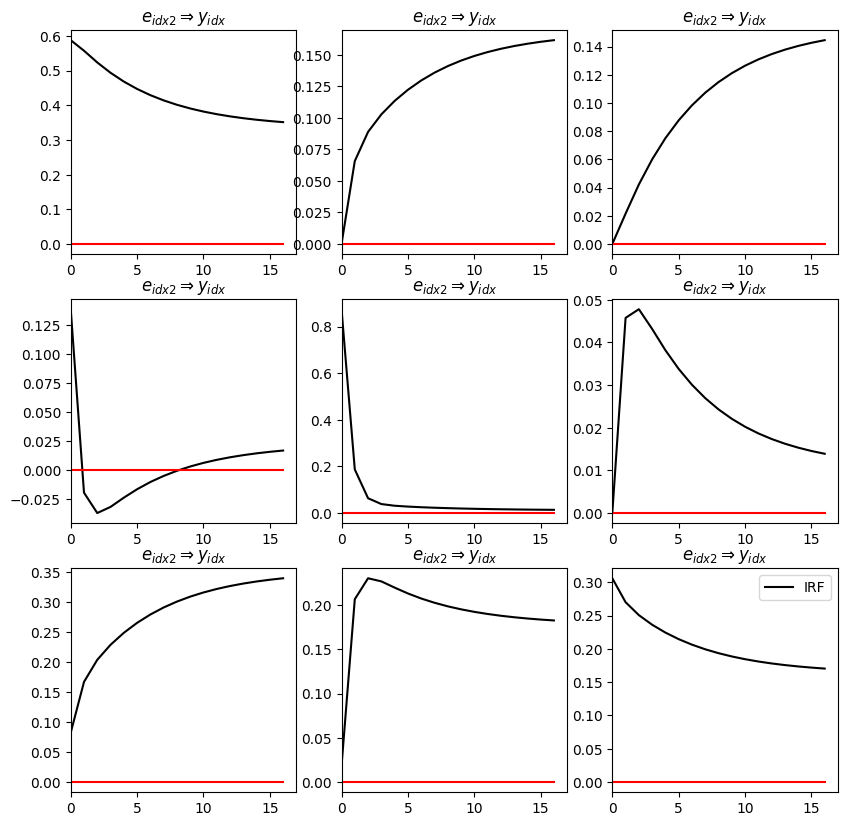

In [15]:
H = 16

Theta = bp.VECM_IRF(y,H,rank,option)